### Proximity

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from scipy.optimize import minimize
from scipy.spatial.distance import cdist, pdist
from scipy import stats
from sklearn.neighbors import DistanceMetric
from tslearn.datasets import UCR_UEA_datasets
from tslearn.neighbors import NearestNeighbors, KNeighborsTimeSeries
from sklearn.metrics import accuracy_score
from scipy.interpolate import interp1d
import tensorflow as tf
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv1D, GlobalAveragePooling1D, BatchNormalization, Conv2D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.backend import function
from sklearn.neighbors import LocalOutlierFactor
from tslearn.utils import to_sklearn_dataset
from tensorflow import keras
print(tf.__version__)
import seaborn as sns
from scipy.spatial import distance

2.4.1


In [2]:
def ucr_data_loader(dataset):
    
    X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset(dataset)
    
    return X_train, y_train, X_test, y_test


def label_encoder(training_labels, testing_labels):
    
    le = preprocessing.LabelEncoder()
    le.fit(np.concatenate((training_labels, testing_labels), axis=0))
    y_train = le.transform(training_labels)
    y_test = le.transform(testing_labels)
    
    return y_train, y_test

In [3]:
def native_guide_retrieval(query, predicted_label, distance, n_neighbors):

    df = pd.DataFrame(y_train, columns = ['label'])
    df.index.name = 'index'
    df[df['label'] == 1].index.values, df[df['label'] != 1].index.values
    
    ts_length = X_train.shape[1]
    

    knn = KNeighborsTimeSeries(n_neighbors=n_neighbors, metric = distance)
    
    knn.fit(X_train[list(df[df['label'] != predicted_label].index.values)])
    
    dist,ind = knn.kneighbors(query.reshape(1,ts_length), return_distance=True)
    return dist[0], df[df['label'] != predicted_label].index[ind[0][:]]

In [4]:
for dataset in ['CBF', 'chinatown', 'coffee', 'ecg200', 'gunpoint']:


    X_train, y_train, X_test, y_test = ucr_data_loader(str(dataset))
    y_train, y_test = label_encoder(y_train, y_test)

    min_edit_cf = np.load('../W-CF/' + str(dataset) + '_wachter_cf.npy')
    cam_swap_cf = np.load('../Native-Guide/' + str(dataset)+'_native_guide_isw.npy')
    
    model = keras.models.load_model('../fcn_weights/'+str(dataset)+'_best_model.hdf5')
    y_pred = np.argmax(model.predict(X_test), axis=1)
    
    nuns = []
    for instance in range(len(X_test)):
        nuns.append(native_guide_retrieval(X_test[instance], y_pred[instance], 'euclidean', 1)[1][0])
    nuns = np.array(nuns)
    
    l1_nun = []
    l1_min_edit = []
    l1_cam_swap = []
    
    l2_nun = []
    l2_min_edit = []
    l2_cam_swap = []
    
    l_inf_nun = []
    l_inf_min_edit = []
    l_inf_cam_swap = []
    

    for instance in range(len(X_test)):

        l1_nun.append(distance.cityblock(X_train[nuns[instance]],X_test[instance]))
        l1_min_edit.append(distance.cityblock(min_edit_cf[instance],X_test[instance]))
        l1_cam_swap.append(distance.cityblock(cam_swap_cf[instance],X_test[instance]))
        
        
        l2_nun.append(np.linalg.norm(X_train[nuns[instance]]-X_test[instance]))
        l2_min_edit.append(np.linalg.norm(min_edit_cf[instance]-X_test[instance]))
        l2_cam_swap.append(np.linalg.norm(cam_swap_cf[instance]-X_test[instance]))
        
        
        l_inf_nun.append(distance.chebyshev(X_train[nuns[instance]],X_test[instance]))
        l_inf_min_edit.append(distance.chebyshev(min_edit_cf[instance],X_test[instance]))
        l_inf_cam_swap.append(distance.chebyshev(cam_swap_cf[instance],X_test[instance]))
        

    print({dataset + '_l1' : (np.mean(np.array(l1_min_edit)/np.array(l1_nun)).round(2), np.mean(np.array(l1_cam_swap)/np.array(l1_nun)).round(2))})
    print({dataset + '_l2' : (np.mean(np.array(l2_min_edit)/np.array(l2_nun)).round(2), np.mean(np.array(l2_cam_swap)/np.array(l2_nun)).round(2))})
    print({dataset + '_l_inf' : (np.mean(np.array(l_inf_min_edit)/np.array(l_inf_nun)).round(2), np.mean(np.array(l_inf_cam_swap)/np.array(l_inf_nun)).round(2))
    })

{'CBF_l1': (0.15, 0.34)}
{'CBF_l2': (0.64, 0.59)}
{'CBF_l_inf': (2.07, 0.85)}
{'chinatown_l1': (0.61, 0.31)}
{'chinatown_l2': (0.93, 0.55)}
{'chinatown_l_inf': (1.52, 0.82)}
{'coffee_l1': (0.13, 0.26)}
{'coffee_l2': (0.57, 0.65)}
{'coffee_l_inf': (1.93, 1.0)}
{'ecg200_l1': (0.1, 0.22)}
{'ecg200_l2': (0.45, 0.5)}
{'ecg200_l_inf': (1.26, 0.84)}
{'gunpoint_l1': (0.13, 0.29)}
{'gunpoint_l2': (0.32, 0.58)}
{'gunpoint_l_inf': (0.91, 0.82)}


### Proximity Analysis and Plotting

Plots for different distances

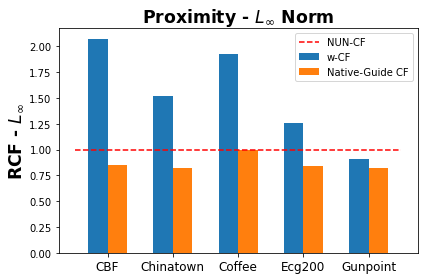

In [5]:
#plt.title(r'W1 disk and central $\pm2^\circ$ subtracted', fontsize='small')


labels = ['CBF', 'Chinatown', 'Coffee', 'Ecg200', 'Gunpoint']

l_inf_w = [2.07,1.52, 1.93, 1.26, 0.91]
l_inf_cam = [0.85,0.82, 1, 0.84, 0.82]



x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, l_inf_w, width, label='w-CF')
rects2 = ax.bar(x + width/2, l_inf_cam, width, label='Native-Guide CF')

ax.hlines(1,xmin=-0.5, xmax=4.5, colors='red', linestyles='--', label='NUN-CF')

ax.set_ylabel('RCF - $L_{\infty}$', size = 'xx-large', fontweight='bold')
ax.set_title('Proximity - $L_{\infty}$ Norm', size='xx-large', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels, size='large')
ax.legend()

fig.tight_layout()
#plt.savefig("../Images/L_inf.pdf")
plt.show()

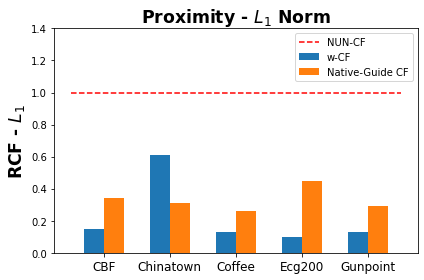

In [6]:
labels = ['CBF', 'Chinatown', 'Coffee', 'Ecg200', 'Gunpoint']

l1_w = [0.15,0.61, 0.13, 0.1, 0.13]
l1_cam = [0.34,0.31, 0.26, 0.45, 0.29]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, l1_w, width, label='w-CF')
rects2 = ax.bar(x + width/2, l1_cam, width, label='Native-Guide CF')

ax.hlines(1,xmin=-0.5, xmax=4.5, colors='red', linestyles='--', label='NUN-CF')

ax.set_ylabel('RCF - $L_{1}$', size = 'xx-large', fontweight='bold')
ax.set_title('Proximity - $L_{1}$ Norm', size='xx-large', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels, size='large')
ax.legend()
ax.set_ylim([0,1.4])

fig.tight_layout()
#plt.savefig("../Images/L_1.pdf")
plt.show()